# Using CLMM on Real Datasets

_the LSST-DESC CLMM team_

This notebook can be run on NERSC.

Here we demonstrate how to run CLMM on real observational datasets. As an example, we use the data from the HSC SSP public releases (Aihara+2018ab, 2019; Mandelbaum+2018ab) (Credit: NAOJ / HSC Collaboration), which have similar observation conditions and data formats to the Rubin LSST.

The steps in this notebook includes:
- [Setting things up](#Setup)
- [Selecting a cluster](#Selecting_a_cluster)
- [Downloading the published catalog at the cluster field](#Downloading_the_catalog)
- [Loading the catalog into CLMM](#Loading_the_catalog)
- [Running CLMM on the dataset](#Running_CLMM)

Links:

The data access of the HSC SSP Public Data Release: 
https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

Shape catalog: 
https://hsc-release.mtk.nao.ac.jp/doc/index.php/s16a-shape-catalog-pdr2/

FAQ: 
https://hsc-release.mtk.nao.ac.jp/doc/index.php/faq__pdr3/

Photometric redshifts:
https://hsc-release.mtk.nao.ac.jp/doc/index.php/photometric-redshifts/

Cluster catalog:
https://hsc-release.mtk.nao.ac.jp/doc/index.php/camira_pdr2/

<a id="Setup"></a>
## 1. Setup
    
We import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table

<a id="Selecting_a_cluster"></a>
## 2. Selecting a cluster

We use the HSC SSP publications (https://hsc.mtk.nao.ac.jp/ssp/publications/) to select a list of reported massive galaxy clusters that have been measured by weak lensing. In the table below, the coordinates are for lensing peaks unless otherwise specified, and we assume h=0.7.

Name | $$z_{cl}$$ | RA (deg) | DEC (deg) | WL $$M_{200,500c} (10^{14} M_{\odot})$$ | Reference | Note
- | - | - | - | - | - | -
HWL16a-094 | 0.592 | 223.0801 | 0.1689 | 15.3, 7.8 | [Hamana+2020](https://ui.adsabs.harvard.edu/abs/2020PASJ...72...78H/abstract) | CAMIRA ID 1417; Miyazaki+2018 rank 34 
HWL16a-026 | 0.424 | 130.5895 | 1.6473 | 8.7, 4.7  | [Hamana+2020](https://ui.adsabs.harvard.edu/abs/2020PASJ...72...78H/abstract) | --
HWL16a-034 | 0.315 | 139.0387 | −0.3966 | 8.1, 5.6 | [Hamana+2020](https://ui.adsabs.harvard.edu/abs/2020PASJ...72...78H/abstract) | Abell 776; MACS J0916.1−0023; Miyazaki+2018 rank 8; see also Medezinski+2018 
Rank 9 | 0.312 | 37.3951 | −3.6099 | --, 5.9 | [Miyazaki+2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..27M/abstract) | --
Rank 48 | 0.529 | 220.7900 | 1.0509 | --, 10.4 | [Miyazaki+2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..27M/abstract) | --
Rank 62 | 0.592 | 216.6510 | 0.7982 | --, 10.2 | [Miyazaki+2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..27M/abstract) | --
MaxBCG J140.53188+03.76632 | 0.2701 | 140.54565 | 3.77820 | 44.3, 25.1 | [Medezinski+2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..28M%2F/abstract) | BCG center (close to the X-ray center); PSZ2 G228.50+34.95; double BCGs
XLSSC006 | 0.429 | 35.439 | −3.772 | 9.6, 5.6 | [Umetsu+2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...890..148U/abstract) | X-ray center



<a id="Downloading_the_catalog"></a>
## 3. Downloading the catalog at the cluster field

We first consider 3 cluster-candidates for the CLMM test because of their large masses: MaxBCG J140.53188+03.76632 (in the GAMA09H field); Miyazaki+2018 (M18 hearafter) rank 48, 62 (in the GAMA15H field).
To download the catalogs, we need to first register for a user account ([link](https://hsc-release.mtk.nao.ac.jp/datasearch/new_user/new)).
Then we log into the system, query and download the catalogs (use `object_id` to cross match the shape catalog, photo-z catalog, and photometry catalog). 
Since the clusters are at redshift about 0.4, we consider a cone search with radius 10 arcmin (about 3 Mpc). 
The final catalog includes shape info, photo-z, and photometry. 
Here is an example of the query SQL command (thank Calum Murray; [example command](https://hsc-release.mtk.nao.ac.jp/doc/index.php/s16a-shape-catalog-pdr2/); [schema](https://hsc-release.mtk.nao.ac.jp/schema/)); the query could take 1 hour and the size of the catalog could be 300 MB (.csv.gz). 

```
select
 b.*, 
 c.ira, c.idec, 
 a.ishape_hsm_regauss_e1, a.ishape_hsm_regauss_e2, 
 a.shape_hsm_regauss_resolution, a.ishape_hsm_regauss_sigma, 
 d.photoz_best, d.photoz_risk_best, 
 e.icmodel_mag, e.icmodel_mag_err, 
 e.detect_is_primary, 
 e.iclassification_extendedness, 
 e.icmodel_flux_flags, 
 e.icmodel_flux, e.icmodel_flux_err, 
 c.iblendedness_abs_flux
from
 s16a_wide.meas2 a
 inner join s16a_wide.weaklensing_hsm_regauss b using (object_id)
 inner join s16a_wide.meas c using (object_id)
 -- inner join s16a_wide.photoz_demp d using (object_id)
 -- inner join s16a_wide.photoz_ephor d using (object_id)
 -- inner join s16a_wide.photoz_ephor_ab d using (object_id)
 -- inner join s16a_wide.photoz_frankenz d using (object_id)
 inner join s16a_wide.photoz_mizuki d using (object_id)
 -- inner join s16a_wide.photoz_mlz d using (object_id)
 -- inner join s16a_wide.photoz_nnpz d using (object_id)
 inner join s16a_wide.forced e using (object_id)
-- Uncomment the specific lines depending upon the field to be used
 -- where s16a_wide.search_xmm(c.skymap_id)
 -- where s16a_wide.search_wide01h(c.skymap_id)
 -- where s16a_wide.search_vvds(c.skymap_id)
 -- where s16a_wide.search_hectomap(c.skymap_id)
 -- where s16a_wide.search_gama15h(c.skymap_id)
 where s16a_wide.search_gama09h(c.skymap_id)
 --AND e.detect_is_primary
 --AND conesearch(c.icoord, 140.54565, 3.77820, 600) 
 --AND NOT e.icmodel_flux_flags
 --AND e.iclassification_extendedness>0.5
 --LIMIT 5
```


<a id="Loading_the_catalog"></a>
## 4. Loading the catalog into CLMM

Once we have the catalog, we read in the catalog, make cuts on the catalog, and adjust column names to prepare for the analysis in CLMM.




In [2]:
# Assume the downloaded catalog is at this path
filename = "../../197299_GAMMA09H.csv"
data_0 = Table.read(filename, format="ascii.csv")

In [15]:
print(data_0.colnames)

['object_id', 'ishape_hsm_regauss_derived_shape_weight', 'ishape_hsm_regauss_derived_shear_bias_m', 'ishape_hsm_regauss_derived_shear_bias_c1', 'ishape_hsm_regauss_derived_shear_bias_c2', 'ishape_hsm_regauss_derived_sigma_e', 'ishape_hsm_regauss_derived_rms_e', 'ira', 'idec', 'ishape_hsm_regauss_e1', 'ishape_hsm_regauss_e2', 'photoz_best', 'photoz_risk_best', 'icmodel_mag', 'icmodel_mag_err', 'detect_is_primary', 'icmodel_flux_flags', 'iclassification_extendedness', 'iblendedness_abs_flux']


In [34]:
# Cuts
def make_cuts(catalog_in):
    # We consider some cuts in Mandelbaum+2018 (HSC SSP Y1 shear catalog)
    select = catalog_in["detect_is_primary"] == "True"
    select &= catalog_in["icmodel_flux_flags"] == "False"
    select &= catalog_in["iclassification_extendedness"] > 0.5
    select &= catalog_in["icmodel_mag_err"] <= 2.5/np.log(10.)/10.
    select &= catalog_in["ishape_hsm_regauss_e1"]**2 + catalog_in["ishape_hsm_regauss_e2"]**2 < 4.
    select &= catalog_in["icmodel_mag"] <= 24.5
    select &= catalog_in["iblendedness_abs_flux"] < (10 ** (-0.375))
    #select &= catalog_in["ishape_hsm_regauss_resolution"] >= 0.3 #similar to extendedness
    #select &= catalog_in["ishape_hsm_regauss_sigma"] <= 0.4
    select &= catalog_in["photoz_risk_best"] < 0.5
    
    catalog_out = catalog_in[select]
    
    return catalog_out

data_1 = make_cuts(data_0)
print(len(data_0), len(data_1), len(data_1)*1./len(data_0))

2967098 2824899 0.9520747208214896


In [43]:
# Adjust column names
def adjust_column_names(catalog_in):
    # We consider a map between new and old column names
    column_name_map = {
        "ra": "ira",
        "dec": "idec",
        "e1": "ishape_hsm_regauss_e1",
        "e2": "ishape_hsm_regauss_e2",
        'z': "photoz_best", 
        "id": "object_id",
    }
    
    catalog_out = Table()
    for i in column_name_map:
        catalog_out[i] = catalog_in[column_name_map[i]]
    
    return catalog_out

data_2 = adjust_column_names(data_1)

        ra                 dec         ...      z              id       
------------------ ------------------- ... ----------- -----------------
135.76127750217105 -1.5870164487552183 ... 0.579999983 39912577030953077
135.76345345826022 -1.5833547337686535 ... 0.600000024 39912577030953209
135.77245457849955 -1.5818157108984277 ... 0.860000014 39912577030953261
135.75595849859593 -1.5817327428974781 ...  1.98000002 39912577030953264
 135.7599358242523 -1.5816591576310965 ... 0.469999999 39912577030953265
135.74851646614815 -1.5813980150363771 ...  1.50999999 39912577030953269
 135.7473562440532 -1.5806648701417918 ... 0.800000012 39912577030953304
 135.7452455941322 -1.5802537099724787 ...        1.25 39912577030953312
135.73930534508708 -1.5788479484929894 ... 0.939999998 39912577030953379
  135.740869762115  -1.578120745954111 ... 0.810000002 39912577030953400
               ...                 ... ...         ...               ...
140.79866321608466   4.464778442662768 ...  1.41999

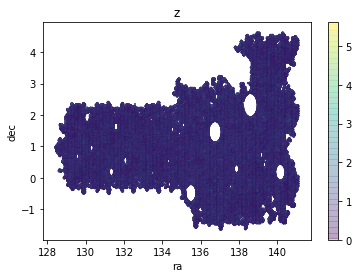

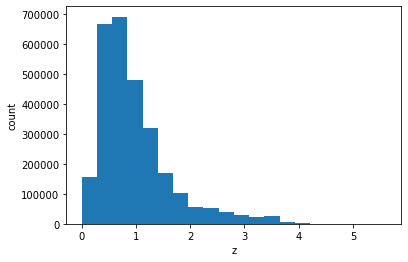

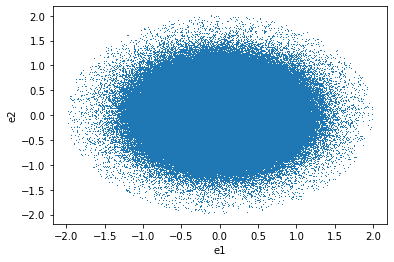

In [44]:
# Make some figures for visualization
def make_plots(catalog_in):
    # Scatter plot
    plt.figure()
    plt.scatter(catalog_in["ra"], catalog_in["dec"], c=catalog_in['z'], s=1., alpha=0.2)
    plt.colorbar()
    plt.xlabel("ra")
    plt.ylabel("dec")
    plt.title("z")
    
    # Histogram
    plt.figure()
    plt.hist(catalog_in['z'], bins=20)
    plt.xlabel('z')
    plt.ylabel("count")
    
    # Relation
    plt.figure()
    plt.plot(catalog_in["e1"], catalog_in["e2"], ',')
    plt.xlabel("e1")
    plt.ylabel("e2")

print(data_2)
make_plots(data_2)

In [45]:
# Source galaxy number density
print(len(data_2)/40./3600.)

19.61735416666667


<a id="Running_CLMM"></a>
## 5. Running CLMM on the dataset
xxx